In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from Heatmap_plot import Heatmap
from Training import GetIMBDDataset
from Nets_original  import GetNeuralNetworkModel
from Stats import WeightQuantization, ActivationStats, CheckAccuracyAndLoss, QuantizationEffect, GetReadAndWrites
from Simulation import buffer_simulation, save_obj, load_obj

tf.random.set_seed(1234)
np.random.seed(1234)

# 1) Training

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Get Dataset

In [2]:
train_batch_size = test_batch_size = 32
train_set,valid_set,test_set  = GetIMBDDataset(train_batch_size, test_batch_size)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Get Model

In [3]:


SentimentalNet = GetNeuralNetworkModel('SentimentalNet',(500),1,quantization = False,aging_active = False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
#metrics = ['accuracy']
# Compile Model
SentimentalNet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ['accuracy'])

TypeError: 'bool' object is not subscriptable

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) Save/Load Weigths

In [4]:
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'SentimentalNet')
wgt_dir = os.path.join(wgt_dir, 'IMBD Reviews Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
#SentimentalNet.load_weights(wgtDir)

# 2) Stats

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  e) Activation Stats

In [5]:
    ActivationStats(SentimentalNet,test_set,14,1,469)

mean value (MMU): 0.0029325176
mean value (Buffer): 0.00909117
maximum (MMU): 0.16042535
minimum (MMU): -0.15042056
maximum (Buffer): 0.52474165
minimum (Buffer): -0.049999762
saturation ratio (MMU): 0.0
saturation ratio (Buffer): 0.0


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  f) Write/Read Stats

In [6]:
Indices  = [1,4,8,12,16]
#Data     = GetReadAndWrites(SentimentalNet,Indices,16000,150,CNN_gating=False)
#stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
#Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data     = GetReadAndWrites(SentimentalNet,Indices,1024*1024,150,CNN_gating=True)
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
CNN_gating_Acceses = pd.DataFrame(stats).reset_index(drop=False)
#save_obj(Baseline_Acceses,'Data/Acceses/SentimentalNet/Baseline')
#save_obj(CNN_gating_Acceses,'Data/Acceses/SentimentalNet/CNN_gating_Fix')

procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150


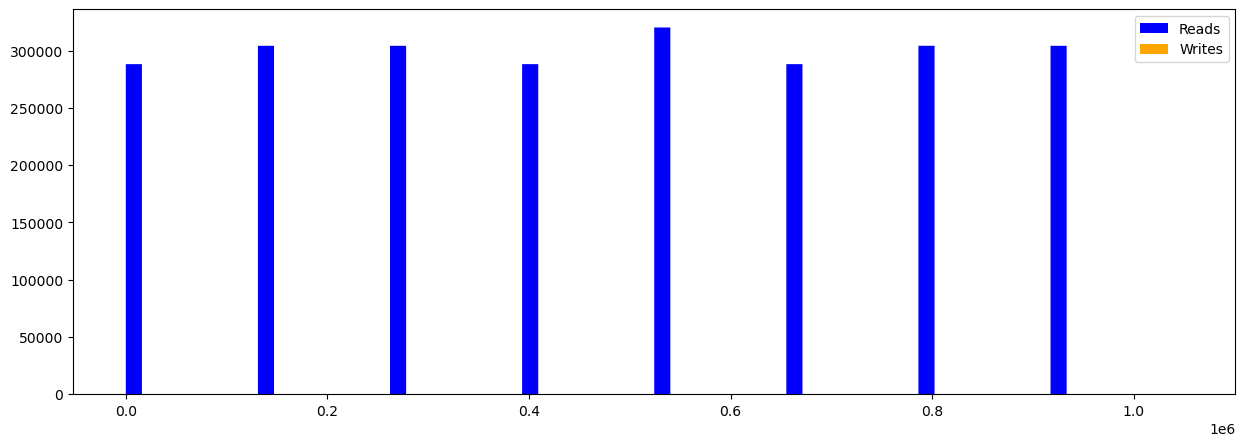

In [7]:
plt.figure(figsize=(15, 5))
plt.stackplot(CNN_gating_Acceses.to_dict()['index'].values(),
              CNN_gating_Acceses.to_dict()['Lecturas'].values(),
              CNN_gating_Acceses.to_dict()['Escrituras'].values(),
              colors=['blue', 'orange'])
plt.legend(['Reads','Writes'])

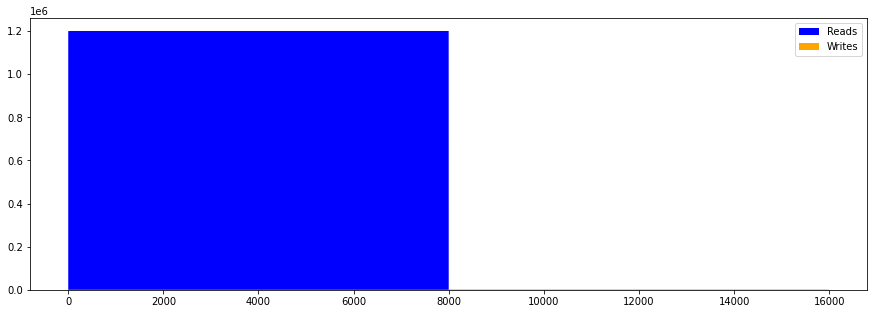

In [36]:
plt.figure(figsize=(15, 5))
plt.stackplot(Baseline_Acceses.to_dict()['index'].values(),
              Baseline_Acceses.to_dict()['Lecturas'].values(),
              Baseline_Acceses.to_dict()['Escrituras'].values(),
              colors=['blue', 'orange'])
plt.legend(['Reads','Writes'])

# 3) Quantization 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Starting Point

In [9]:
CheckAccuracyAndLoss('SentimentalNet', test_set, wgt_dir, act_frac_size = 16, act_int_size = 16, wgt_frac_size = 16, wgt_int_size = 16, 
                    input_shape = (500), output_shape = 1, batch_size = test_batch_size);

ValueError: Shapes (16000, 250) and (8000, 250) are incompatible

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Number of bits analysis

In [40]:
df = QuantizationEffect('SentimentalNet',test_set,wgt_dir,(500),1,test_batch_size)
#save_obj(df,'Data/Quantization/SentimentalNet/IMDB Reviews Dataset/Quantization')

Estoy aquí en el efecto d ecuantización
Activation fraction part
aging_active en AddCustomLayers False
dentro de includin Aging False
dentro de GenerateAddressList 
aging_active dentro de aging_argiments False
aging_active en AddCustomLayers False
dentro de includin Aging False
dentro de GenerateAddressList 
aging_active dentro de aging_argiments False
aging_active en AddCustomLayers False
dentro de includin Aging False
dentro de GenerateAddressList 
aging_active dentro de aging_argiments False
aging_active en AddCustomLayers False
dentro de includin Aging False
dentro de GenerateAddressList 
aging_active dentro de aging_argiments False
aging_active en AddCustomLayers False
aging_active en AddCustomLayers False


ValueError: Shapes (16000, 250) and (8000, 250) are incompatible

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; f) Used Config

In [43]:
CheckAccuracyAndLoss('SentimentalNet', test_set, wgt_dir, act_frac_size = 14, act_int_size = 1, wgt_frac_size = 15, wgt_int_size = 0, 
                    input_shape = (500), output_shape = 1, batch_size = test_batch_size);

aging_active en AddCustomLayers False
dentro de includin Aging False
dentro de GenerateAddressList 
aging_active dentro de aging_argiments False
aging_active en AddCustomLayers False
dentro de includin Aging False
dentro de GenerateAddressList 
aging_active dentro de aging_argiments False
aging_active en AddCustomLayers False
dentro de includin Aging False
dentro de GenerateAddressList 
aging_active dentro de aging_argiments False
aging_active en AddCustomLayers False
dentro de includin Aging False
dentro de GenerateAddressList 
aging_active dentro de aging_argiments False
aging_active en AddCustomLayers False
aging_active en AddCustomLayers False


ValueError: Shapes (16000, 250) and (8000, 250) are incompatible

# 3) Buffer Simulation

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Baseline

In [7]:
trainBatchSize = testBatchSize = 1
_,_,testSet = GetIMBDDataset(train_batch_size=1, test_batch_size=1)

QSentimentalNet  = GetNeuralNetworkModel('SentimentalNet',(500),1,quantization = True, aging=False,wordSize = 16, fracSize = 15)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
QSentimentalNet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
QSentimentalNet.load_weights(wgtDir).expect_partial()
WeightQuantization(model = QSentimentalNet, fracBits = 15, intBits = 0)


LI = [1,4,8,12,16]
AI = [3,7,10,15,19]
buffer_simulation(QSentimentalNet,testSet, integer_bits = 0, fractional_bits = 15, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/SentimentalNet/IMDB Reviews Dataset/Baseline/',buffer_size = 2*16000,
                 layer_indexes = LI , activation_indixes = AI)

buffer sections:  [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000]
Simulation Started, time: 12:42:40 cycles:  0 offset:  0
procesed images: 0  time: 12:42:43 cycles:  13106 offset:  0
procesed images: 1  time: 12:42:44 cycles:  26212 offset:  0
procesed images: 2  time: 12:42:46 cycles:  39318 offset:  0
procesed images: 3  time: 12:42:47 cycles:  52424 offset:  0
procesed images: 4  time: 12:42:49 cycles:  65530 offset:  0
procesed images: 5  time: 12:42:50 cycles:  78636 offset:  0
procesed images: 6  time: 12:42:52 cycles:  91742 offset:  0
procesed images: 7  time: 12:42:52 cycles:  104848 offset:  0
procesed images: 8  time: 12:42:54 cycles:  117954 offset:  0
procesed images: 9  time: 12:42:55 cycles:  131060 offset:  0
procesed images: 10  time: 12:42:57 cycles:  144166 offset:  0
procesed images: 11  time: 12:42:58 cycles:  157272 offset:  0
procesed images: 12  time: 12:43:00 cycles:  170378 offset:  0
procesed images: 13  time: 12:43:01 cycles:  183484 offset:  0
proc

procesed images: 127  time: 12:45:35 cycles:  1677568 offset:  0
procesed images: 128  time: 12:45:37 cycles:  1690674 offset:  0
procesed images: 129  time: 12:45:38 cycles:  1703780 offset:  0
procesed images: 130  time: 12:45:40 cycles:  1716886 offset:  0
procesed images: 131  time: 12:45:40 cycles:  1729992 offset:  0
procesed images: 132  time: 12:45:43 cycles:  1743098 offset:  0
procesed images: 133  time: 12:45:43 cycles:  1756204 offset:  0
procesed images: 134  time: 12:45:45 cycles:  1769310 offset:  0
procesed images: 135  time: 12:45:46 cycles:  1782416 offset:  0
procesed images: 136  time: 12:45:48 cycles:  1795522 offset:  0
procesed images: 137  time: 12:45:49 cycles:  1808628 offset:  0
procesed images: 138  time: 12:45:51 cycles:  1821734 offset:  0
procesed images: 139  time: 12:45:51 cycles:  1834840 offset:  0
procesed images: 140  time: 12:45:53 cycles:  1847946 offset:  0
procesed images: 141  time: 12:45:54 cycles:  1861052 offset:  0
procesed images: 142  tim

({'Number of Addresses': 16000,
  'Data': array([0, 0, 0, ..., 1, 1, 0], dtype=int8),
  'HighCyclesCount': array([330836,  26792,  32308, ..., 816060, 629082, 955544], dtype=uint32),
  'OffCyclesCount': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
  'LowCyclesCount': array([1635064, 1939108, 1933592, ..., 1149840, 1336818, 1010356],
        dtype=uint32),
  'Flips': array([146,  68,  82, ...,  85,  67,  88], dtype=uint32),
  'offset': 0},
 1965900)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; CNN-Gated, case 1

In [8]:
trainBatchSize = testBatchSize = 1
_,_,testSet = GetIMBDDataset(train_batch_size=1, test_batch_size=1)

QSentimentalNet  = GetNeuralNetworkModel('SentimentalNet',(500),1,quantization = True, aging=False,wordSize = 16, fracSize = 15)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
QSentimentalNet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
QSentimentalNet.load_weights(wgtDir).expect_partial()
WeightQuantization(model = QSentimentalNet, fracBits = 15, intBits = 0)


LI = [1,4,8,12,16]
AI = [3,7,10,15,19]
buffer_simulation(QSentimentalNet,testSet, integer_bits = 0, fractional_bits = 15, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = True, write_mode ='default',
                 results_dir = 'Data/Stats/SentimentalNet/IMDB Reviews Dataset/CNN-Gated/Full Buffer',buffer_size = 2*1024*1024,
                 layer_indexes = LI , activation_indixes = AI)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
c:\users\nicol\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
c:\users\nicol\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you m

buffer sections:  [0, 131072, 262144, 393216, 524288, 655360, 786432, 917504, 1048576]
Simulation Started, time: 12:53:19 cycles:  0 offset:  0
procesed images: 0  time: 12:53:24 cycles:  13106 offset:  393216
procesed images: 1  time: 12:53:26 cycles:  26212 offset:  655360
procesed images: 2  time: 12:53:29 cycles:  39318 offset:  1048576
procesed images: 3  time: 12:53:31 cycles:  52424 offset:  262144
procesed images: 4  time: 12:53:34 cycles:  65530 offset:  655360
procesed images: 5  time: 12:53:35 cycles:  78636 offset:  917504
procesed images: 6  time: 12:53:38 cycles:  91742 offset:  262144
procesed images: 7  time: 12:53:40 cycles:  104848 offset:  524288
procesed images: 8  time: 12:53:43 cycles:  117954 offset:  917504
procesed images: 9  time: 12:53:45 cycles:  131060 offset:  131072
procesed images: 10  time: 12:53:48 cycles:  144166 offset:  524288
procesed images: 11  time: 12:53:49 cycles:  157272 offset:  786432
procesed images: 12  time: 12:53:53 cycles:  170378 offs

procesed images: 118  time: 12:58:12 cycles:  1559614 offset:  262144
procesed images: 119  time: 12:58:14 cycles:  1572720 offset:  524288
procesed images: 120  time: 12:58:17 cycles:  1585826 offset:  917504
procesed images: 121  time: 12:58:19 cycles:  1598932 offset:  131072
procesed images: 122  time: 12:58:22 cycles:  1612038 offset:  524288
procesed images: 123  time: 12:58:24 cycles:  1625144 offset:  786432
procesed images: 124  time: 12:58:27 cycles:  1638250 offset:  131072
procesed images: 125  time: 12:58:29 cycles:  1651356 offset:  393216
procesed images: 126  time: 12:58:32 cycles:  1664462 offset:  786432
procesed images: 127  time: 12:58:34 cycles:  1677568 offset:  1048576
procesed images: 128  time: 12:58:37 cycles:  1690674 offset:  393216
procesed images: 129  time: 12:58:39 cycles:  1703780 offset:  655360
procesed images: 130  time: 12:58:42 cycles:  1716886 offset:  1048576
procesed images: 131  time: 12:58:44 cycles:  1729992 offset:  262144
procesed images: 1

({'Number of Addresses': 1048576,
  'Data': array([2, 2, 2, ..., 2, 2, 2], dtype=int8),
  'HighCyclesCount': array([ 82694,  34413,  33215, ...,  97722, 111114, 144354], dtype=uint32),
  'OffCyclesCount': array([1727008, 1727008, 1727008, ..., 1735500, 1735500, 1735500],
        dtype=uint32),
  'LowCyclesCount': array([156198, 204479, 205677, ..., 132678, 119286,  86046], dtype=uint32),
  'Flips': array([25, 22, 17, ...,  0,  0,  0], dtype=uint32),
  'offset': 917504},
 1965900)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; CNN-Gated, case 2

In [9]:
trainBatchSize = testBatchSize = 1
_,_,testSet = GetIMBDDataset(train_batch_size=1, test_batch_size=1)

QSentimentalNet  = GetNeuralNetworkModel('SentimentalNet',(500),1,quantization = True, aging=False,wordSize = 16, fracSize = 15)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
QSentimentalNet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
QSentimentalNet.load_weights(wgtDir).expect_partial()
WeightQuantization(model = QSentimentalNet, fracBits = 15, intBits = 0)


LI = [1,4,8,12,16]
AI = [3,7,10,15,19]
buffer_simulation(QSentimentalNet,testSet, integer_bits = 0, fractional_bits = 15, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = True, write_mode ='default',
                 results_dir = 'Data/Stats/SentimentalNet/IMDB Reviews Dataset/CNN-Gated/', buffer_size = 2*16000,
                 layer_indexes = LI , activation_indixes = AI)

buffer sections:  [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000]
Simulation Started, time: 13:00:41 cycles:  0 offset:  0
procesed images: 0  time: 13:00:44 cycles:  13106 offset:  10000
procesed images: 1  time: 13:00:45 cycles:  26212 offset:  12000
procesed images: 2  time: 13:00:47 cycles:  39318 offset:  6000
procesed images: 3  time: 13:00:48 cycles:  52424 offset:  8000
procesed images: 4  time: 13:00:50 cycles:  65530 offset:  2000
procesed images: 5  time: 13:00:50 cycles:  78636 offset:  4000
procesed images: 6  time: 13:00:52 cycles:  91742 offset:  14000
procesed images: 7  time: 13:00:53 cycles:  104848 offset:  16000
procesed images: 8  time: 13:00:55 cycles:  117954 offset:  10000
procesed images: 9  time: 13:00:56 cycles:  131060 offset:  12000
procesed images: 10  time: 13:00:58 cycles:  144166 offset:  6000
procesed images: 11  time: 13:00:58 cycles:  157272 offset:  8000
procesed images: 12  time: 13:01:00 cycles:  170378 offset:  2000
procesed images: 13  t

procesed images: 121  time: 13:03:27 cycles:  1598932 offset:  12000
procesed images: 122  time: 13:03:29 cycles:  1612038 offset:  6000
procesed images: 123  time: 13:03:30 cycles:  1625144 offset:  8000
procesed images: 124  time: 13:03:32 cycles:  1638250 offset:  2000
procesed images: 125  time: 13:03:33 cycles:  1651356 offset:  4000
procesed images: 126  time: 13:03:35 cycles:  1664462 offset:  14000
procesed images: 127  time: 13:03:35 cycles:  1677568 offset:  16000
procesed images: 128  time: 13:03:37 cycles:  1690674 offset:  10000
procesed images: 129  time: 13:03:38 cycles:  1703780 offset:  12000
procesed images: 130  time: 13:03:40 cycles:  1716886 offset:  6000
procesed images: 131  time: 13:03:41 cycles:  1729992 offset:  8000
procesed images: 132  time: 13:03:43 cycles:  1743098 offset:  2000
procesed images: 133  time: 13:03:44 cycles:  1756204 offset:  4000
procesed images: 134  time: 13:03:46 cycles:  1769310 offset:  14000
procesed images: 135  time: 13:03:46 cycle

({'Number of Addresses': 16000,
  'Data': array([2, 2, 2, ..., 2, 2, 2], dtype=int8),
  'HighCyclesCount': array([304464,  42996,  47890, ..., 244240, 197748, 394506], dtype=uint32),
  'OffCyclesCount': array([989076, 989076, 989076, ..., 845292, 845292, 845292], dtype=uint32),
  'LowCyclesCount': array([672360, 933828, 928934, ..., 876368, 922860, 726102], dtype=uint32),
  'Flips': array([126,  89,  94, ...,  98, 105, 125], dtype=uint32),
  'offset': 4000},
 1965900)

# 4) Error Injection

In [5]:
trainSet,validSet,testSet = GetIMBDDataset(32, 32)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Measuring effect of errors by buffer,section,number of faults and bit localization of the fault

In [ ]:
import itertools
from copy import deepcopy
from Quantization_and_Errors import Check_Accuracy_and_Loss
from Simulation import save_obj, load_obj
from datetime import datetime

Start_from_zero = False

if Start_from_zero:
    Accs     = {0.0001:[],0.0005:[],0.001:[],0.005:[],0.01:[]}
    Loss     = {0.0001:[],0.0005:[],0.001:[],0.005:[],0.01:[]}
else:
    Accs     = load_obj('Data/Errors/SentimentalNet/IMDB Reviews Dataset/Accs')
    Loss     = load_obj('Data/Errors/SentimentalNet/IMDB Reviews Dataset/Loss')
    
cell_modifications = list(itertools.product(['1', 'x','0'], repeat=16))
possible_errors_under_8000 = ["".join(i) for i in cell_modifications]
cell_modifications = list(itertools.product(['1', 'x','0'], repeat=5))
possible_errors_above_8000 = ['x'+"".join(i)+'xxxxxxxxxx' for i in cell_modifications]


Num_of_samples = 200
for Enumber in Accs:
    for index in range(0,Num_of_samples):
        if index < Num_of_samples//2:
            mask = [True,False,True,False]
        else:
            mask = [False,True,False,True]
        number_of_errors = np.ceil(Enumber*8000).astype(int)
        locs1      = np.random.choice(range(0,8000),number_of_errors,False)
        Errortype1 = np.random.choice(possible_errors_under_8000, number_of_errors, True)
        locs2      = np.random.choice(range(8000,16000),number_of_errors,False)
        Errortype2 = np.random.choice(possible_errors_above_8000, number_of_errors, True)
        locs       = np.concatenate([locs1,locs2])
        Errortype  = np.concatenate([Errortype1,Errortype2])
        acc,loss   = CheckAccuracyAndLoss('PilotNet', test_dataset, wgtDir, outputShape=1, inputShape = (500),
                                            aFracSize = 14, aIntSize = 1, wFracSize = 15, wIntSize = 0,
                                            batchSize=32, verbose = 0, aging = mask,
                                            faultyAddresses = locs, maskedFaults = Errortype)
        Accs[Enumber].append(acc)
        Loss[Enumber].append(loss)
        if index % 10 == 0:
            print(index)
    print(str(Enumber)+' completada: ', datetime.now().strftime("%H:%M:%S"))
    #save_obj(Accs,'Data/Errors/SentimentalNet/IMDB Reviews Dataset/Accs')
    #save_obj(Loss,'Data/Errors/SentimentalNet/IMDB Reviews Dataset/Loss')